In [1]:
import sys
import os
from os.path import exists
import numpy as np
import pandas as pd
import pickle
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl
import importlib
import imp
sys.path.insert(1,'/data1/gridsan/groups/manthiram_lab/Utils')
import plot as pl
from utils import make_xyz_from_output,checkvibs, check, no_to_symbol
import PyEnergyDiagrams.energydiagram
from PyEnergyDiagrams.energydiagram import ED

from rdkit import Chem
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.Draw import rdMolDraw2D,MolToImage,ShowMol,MolsToGridImage

from IPython.display import SVG
import tempfile

import cairosvg

In [2]:
imp.reload(PyEnergyDiagrams.energydiagram)

<module 'PyEnergyDiagrams.energydiagram' from '/data1/gridsan/groups/manthiram_lab/Utils/PyEnergyDiagrams/energydiagram/__init__.py'>

# Load Necessary Data

In [3]:
df=pd.read_csv('../sheets/Ylides_YlideRads_Cleaned.csv')
y=df['Ylides'].to_list()
yr=df['Ylides Rad'].to_list()
yh=df['Ylides H'].to_list()

In [4]:
with open("../pickled_data/num_atoms.pkl","rb") as file: #This may have been overwritten in the data_analysis code
    pickle_off = pkl.Unpickler(file)
    num_atoms= pickle_off.load()

with open("../pickled_data/num_atoms_total.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    num_atoms_total= pickle_off.load()
    
with open("../pickled_data/wall_time_gas.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    wall_time_gas= pickle_off.load()
    
with open("../pickled_data/wall_time_solv.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    wall_time_solv= pickle_off.load()   
    
with open("../pickled_data/failed_dict_gas.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    failed_dict_gas= pickle_off.load()
    
with open("../pickled_data/failed_dict_solv.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    failed_dict_solv= pickle_off.load()
    
with open("../pickled_data/bde_dict_M062X_Def2SVPD.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    bde_dict= pickle_off.load()
    
with open("../pickled_data/freqs_solv.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    freqs_solv= pickle_off.load()

with open("../pickled_data/check_freqs_solv.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    check_freqs_solv= pickle_off.load()
    
with open("../python_scripts/dicts/failed_dict_solv_0823.pkl","rb") as file: 
    pickle_off = pkl.Unpickler(file)
    failed_dict_solv= pickle_off.load()
    
    
data_gas=np.load(f'../pickled_data/data_gas.npy')
data_solv=np.load(f'../pickled_data/data_solv.npy')
data=[data_gas,data_solv]
wall_time=[wall_time_gas,wall_time_solv]
freqs=[[],freqs_solv]
cehck_freqs=[[],check_freqs_solv]

In [5]:
special_gas_cases_1=np.where( (data_gas[:,9]<-1200) | (data_solv[:,9]> 400) ) 
special_gas_cases_2=np.where( (data_gas[:,7]>6) | (data_gas[:,7]<-1 ) )
special_gas_cases_3=np.where( (data_gas[:,8]>1200) | (data_gas[:,8]<200) )            
a=np.array(list(set(np.concatenate((special_gas_cases_1[0], special_gas_cases_2[0],special_gas_cases_3[0])))))
a.sort()
                     
special_solv_cases_1=np.where( (data_solv[:,9]<-600) | (data_solv[:,9]> 400) )
special_solv_cases_2=np.where((data_solv[:,7]>6) | (data_solv[:,7]<-1) )
special_solv_cases_3=np.where( (data_solv[:,8]>1200) | (data_solv[:,8]<400))
b=np.array(list(set(np.concatenate((special_solv_cases_1[0], special_solv_cases_2[0],special_solv_cases_3[0])))))
b.sort()

special_cases=[a,b]

In [6]:
for key, value in failed_dict_solv.items():
    print(f'{key} has {len(value)} failures and a fail percentage of {len(value)/10000*100:.3f}%')

ylide_gas_preopt has 13 failures and a fail percentage of 0.130%
ylide_rad_gas_preopt has 82 failures and a fail percentage of 0.820%
ylide_h_gas_preopt has 25 failures and a fail percentage of 0.250%


In [7]:
dicts= [failed_dict_gas, failed_dict_solv]
succ=[[],[]]
all_failures=[[],[]]


for i,v in enumerate(dicts):
    for key, value in v.items():
        all_failures[i]= all_failures[i]+ value

    for j in special_cases[i]:
        all_failures[i].append(j)

    all_failures[i]=list(set(all_failures[i]))

    all_failures[i].sort()

    #Get Values that worked

    n,d=np.shape(data[i])

    for j in range(n):
        if j not in all_failures[i]:
            succ[i].append(j)
        



## Plot Characteristics of Ylide Library

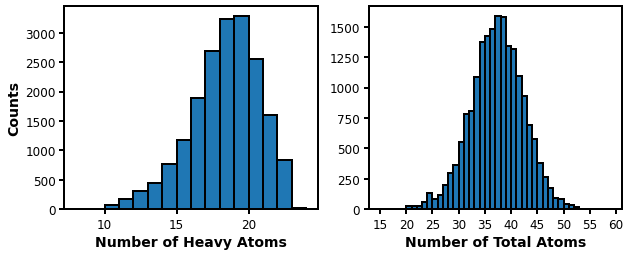

In [8]:
#plot
b=list(range(8,25))
b2=list(range(15,60))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))
pl.hist(ax1,num_atoms,bins=b,xlabel='Number of Heavy Atoms',ylabel='Counts',fontsize=14,labelsize=12)
pl.hist(ax2,num_atoms_total,bins=b2,xlabel='Number of Total Atoms',ylabel='',fontsize=14,labelsize=12)
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax1.xaxis.set_major_locator(xloc)
ax2.xaxis.set_major_locator(xloc)
plt.savefig(f'../Figures/Num_atoms.png',dpi=600)

# Time Statistics

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.


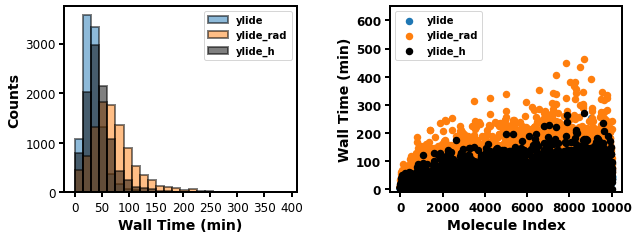

In [8]:
#gas phase
ylide_type=[['ylide',''],['ylide_rad','_y_h_opt'],['ylide_h','']]
solvorgas='solv'
#wall_time=wall_time_gas

b=list(range(0,400,15))
#b2=list(range(15,60))
wt=1

wall_time_array=np.array(wall_time[wt])
n,d=np.shape(wall_time_array)
colors=['tab:blue','tab:orange','black']
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,10))

for i in range(3):
    #pl.hist(ax1,list(np.reshape(wall_time_array,(1,n*d))/60),bins=b,xlabel='Wall Time (min)',ylabel='Counts',fontsize=14,labelsize=12)
    pl.hist(ax1,wall_time_array[i,:]/60,bins=b,xlabel='Wall Time (min)',ylabel='Counts',fontsize=14,labelsize=12,color=colors[i],alpha=0.5,label=f'{ylide_type[i][0]}')
    
ax1.legend(prop={'family':'arial','size':10,'weight':'bold'}) 
ax2.set_ylim(-10,650)


for i in range(3):
    pl.scatter(ax2,range(d),wall_time_array[i,:]/60,xlabel='Molecule Index',ylabel='Wall Time (min)',label=f'{ylide_type[i][0]}',fontsize=14,labelsize=12,facecolor=colors[i],edgecolor=colors[i])

    
ax2.legend(prop={'family':'arial','size':10,'weight':'bold'})  
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
#ax1.xaxis.set_major_locator(xloc)
ax1.xaxis.set_major_locator(xloc)

plt.subplots_adjust(wspace=0.4)
plt.savefig(f'../Figures/Wall_time_{solvorgas}.png',dpi=600)

##### Print Average Wall Times

In [10]:
for i in range(3):
    print(f' Wall time for {ylide_type[i][0]}  was  {wall_time_array[i][np.nonzero(wall_time_array[i])].mean()/3600 :.3f} hours ')
    

NameError: name 'ylide_type' is not defined

### Make Gas Data Frame Removing All Failures

In [11]:
cleaned_gas=np.empty((len(succ[0]),5),dtype='object')
for i,v in enumerate(succ[0]):
    d=data[0]
    cleaned_gas[i,0]= y[v]
    cleaned_gas[i,1]= d[v,7] #Redox
    cleaned_gas[i,2]= d[v,8] #DP
    cleaned_gas[i,3]= d[v,9] #GHbind
    cleaned_gas[i,4]= v

df=pd.DataFrame(data=cleaned_gas,columns=['smiles','redox potential (V)','DPFE (kJ/mol)','GHbind (kJ/mol)','Original Index'])
df.to_csv('Ylide_Gas_SpecialCases_Removed.csv',index=False)

### Make Solv Data Frame Removing All Failures

In [17]:
cleaned_solv=np.empty((len(succ[1]),5),dtype='object')
for i,v in enumerate(succ[1]):
    d=data[1]
    cleaned_solv[i,0]= y[v]
    cleaned_solv[i,1]= d[v,7] #Redox
    cleaned_solv[i,2]= d[v,8] #DP
    cleaned_solv[i,3]= d[v,9] #GHbind
    cleaned_solv[i,4]= v

df=pd.DataFrame(data=cleaned_solv,columns=['smiles','redox potential (V)','DPFE (kJ/mol)','GHbind (kJ/mol)','Original Index'])
df.to_csv('Ylide_Solv_SpecialCases_Removed.csv',index=False)

### Gas Phase

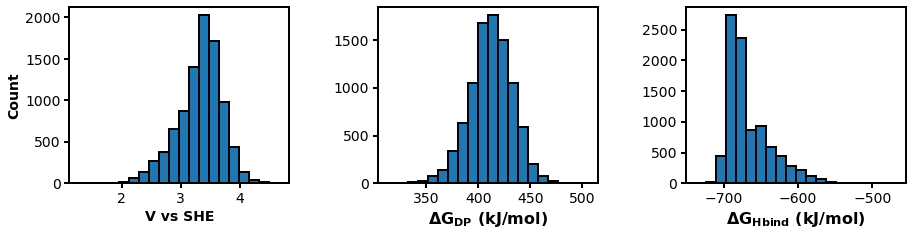

In [56]:
functional='M062X'
basis= 'Def2TZVP'
solvorgas='gas'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,15))
pl.hist(ax1,data[0][succ[0],7],color='tab:blue',xlabel='V vs SHE',ylabel='Count',labelsize=14,fontsize=14)
pl.hist(ax2,data[0][succ[0],8],color='tab:blue',xlabel=f'{dpfe} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
pl.hist(ax3,data[0][succ[0],9],color='tab:blue',xlabel=f'{ghb} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
max_xticks = 8
xloc = plt.MaxNLocator(max_xticks)

plt.subplots_adjust(wspace=0.4)
plt.savefig(f'../Figures/Energy_Hist_{solvorgas}.png',dpi=600)

### Solution Phase

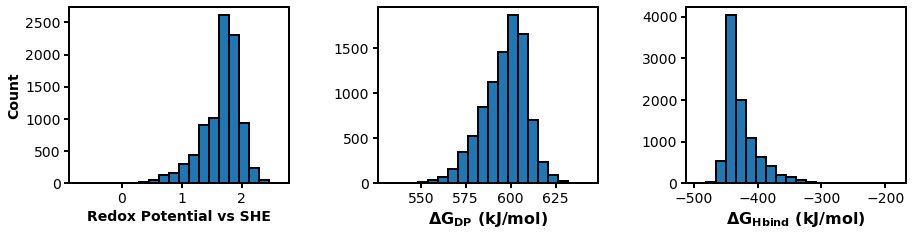

In [45]:
#Solution Phase
functional='M062X'
basis= 'Def2TZVP'
solvorgas='solv'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,15))
pl.hist(ax1,data[1][succ[1],7],color='tab:blue',xlabel='Redox Potential vs SHE',ylabel='Count',labelsize=14,fontsize=14)
pl.hist(ax2,data[1][succ[1],8],color='tab:blue',xlabel=f'{dpfe} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
pl.hist(ax3,data[1][succ[1],9],color='tab:blue',xlabel=f'{ghb} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
max_xticks = 8

xloc = plt.MaxNLocator(max_xticks)
plt.subplots_adjust(wspace=0.4)

plt.savefig(f'../Figures/Energy_Hist_{solvorgas}.png',dpi=600)

### Compare Gas and Solution Phase

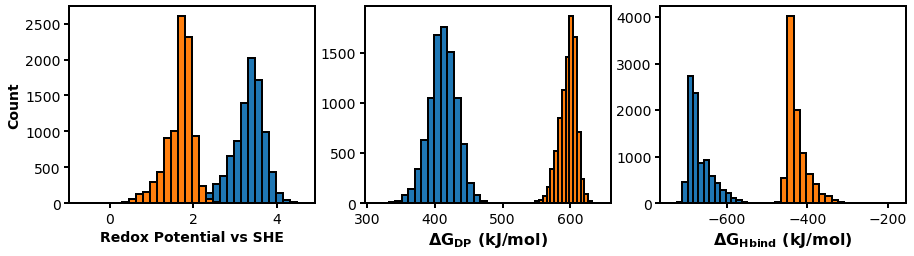

In [59]:
dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,15))

pl.hist(ax1,data[0][succ[0],7],color='tab:blue',xlabel='V vs SHE',ylabel='Count',labelsize=14,fontsize=14)
pl.hist(ax2,data[0][succ[0],8],color='tab:blue',xlabel=f'{dpfe} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
pl.hist(ax3,data[0][succ[0],9],color='tab:blue',xlabel=f'{ghb} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)

pl.hist(ax1,data[1][succ[1],7],color='tab:orange',xlabel='Redox Potential vs SHE',ylabel='Count',labelsize=14,fontsize=14)
pl.hist(ax2,data[1][succ[1],8],color='tab:orange',xlabel=f'{dpfe} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
pl.hist(ax3,data[1][succ[1],9],color='tab:orange',xlabel=f'{ghb} (kJ/mol)',ylabel='',labelsize=14,fontsize=16)
max_xticks = 8
plt.savefig(f'../Figures/Energy_Hist_comparison.png',dpi=600)

# Scatter Plots

### Gas phase

findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.


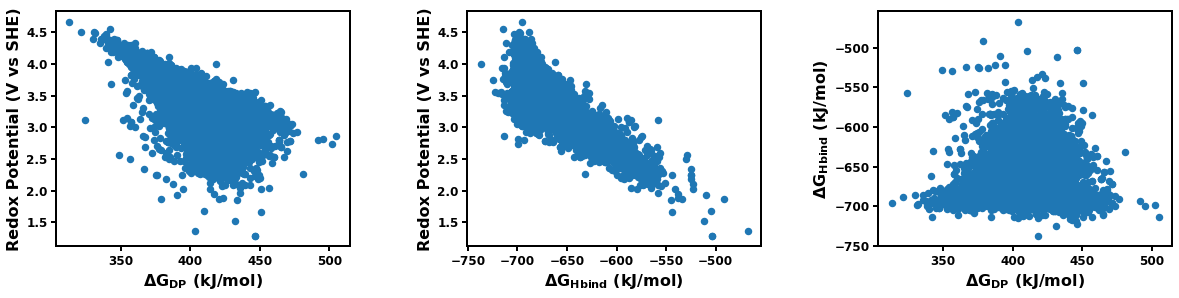

In [20]:
#plot
#Solution Phase
functional='M062X'
basis= 'Def2TZVP'
solvorgas='gas'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

ylide_type=[['ylide',''],['ylide_rad','_y_h_opt'],['ylide_h','']]
colors=['tab:blue','tab:orange','black']
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))


pl.scatter(ax1,data[0][succ[0],8],data[0][succ[0],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{dpfe} (kJ/mol)',fontsize=16,labelsize=12)
pl.scatter(ax2,data[0][succ[0],9],data[0][succ[0],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)
pl.scatter(ax3,data[0][succ[0],8],data[0][succ[0],9],xlabel=f'{dpfe} (kJ/mol)',ylabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)
plt.subplots_adjust(wspace=0.4)

plt.savefig(f'../Figures/Energy_Scatter_{solvorgas}.png',dpi=600)

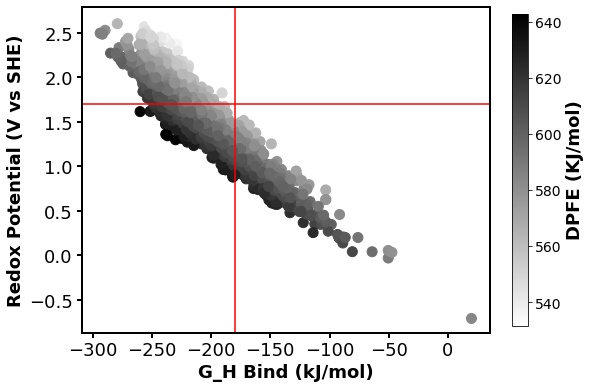

In [31]:
fig,ax1=plt.subplots(1,1,figsize=(8,8))

solvorgas='solv'

data_id={
    'solv':1,
    'gas':0
}
di=data_id[solvorgas]

sc=ax1.scatter(data[di][succ[di],9],data[di][succ[di],7],s=100,c=data[di][succ[di],8],cmap='binary',vmin=min(data[di][succ[di],8]),vmax=max(data[di][succ[di],8]))
# ax1.set_xlim(-300,0)
# ax1.set_ylim(0.5,3)
# mat = np.random.random(data[succ_gas,9])
plt.axhline(y=1.7, xmin=0, xmax=1,color='r')
plt.axvline(x=-180, ymin=0, ymax=1,color='r')
cb=plt.colorbar(sc,fraction=0.035, pad=0.05)
cb.set_label(label='DPFE (KJ/mol)',size=18,weight='bold')
cb.ax.tick_params(labelsize=14) 
pl.set(ax1,ylabel='Redox Potential (V vs SHE)',xlabel='G_H Bind (kJ/mol)',edgecolor='black',fontsize=18,labelsize=18)

plt.savefig(f'../Figures/Energy_Scatter_3D{solvorgas}.png',dpi=600)

## Solution phase

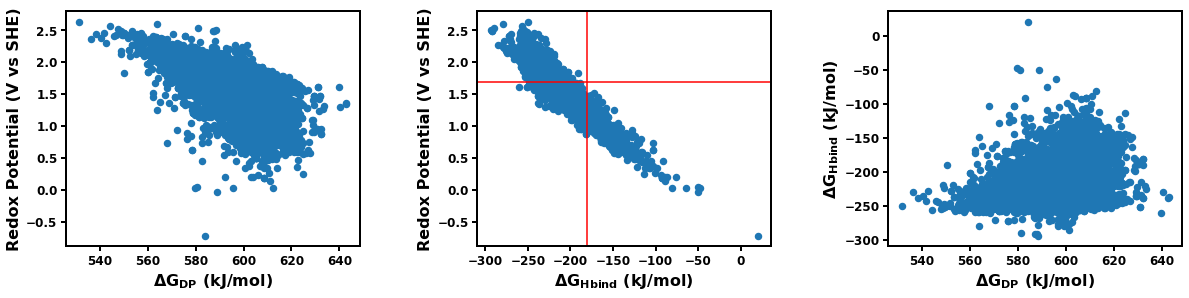

In [29]:

#Solution Phase

functional='M062X'
basis= 'Def2SVPD'
solvorgas='solv'
solvmethod='SMD'

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

ylide_type=[['ylide',''],['ylide_rad','_y_h_opt'],['ylide_h','']]
colors=['tab:blue','tab:orange','black']
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,10))

pl.scatter(ax1,data[1][succ[1],8],data[1][succ[1],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{dpfe} (kJ/mol)',fontsize=16,labelsize=12)
pl.scatter(ax2,data[1][succ[1],9],data[1][succ[1],7],ylabel='Redox Potential (V vs SHE)',xlabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)
ax2.axhline(y=1.7, xmin=0, xmax=1,color='r')
ax2.axvline(x=-180, ymin=0, ymax=1,color='r')
pl.scatter(ax3,data[1][succ[1],8],data[1][succ[1],9],xlabel=f'{dpfe} (kJ/mol)',ylabel=f'{ghb} (kJ/mol)',fontsize=16,labelsize=12)

plt.subplots_adjust(wspace=0.4)

plt.savefig(f'../Figures/Energy_Scatter_{solvorgas}.png',dpi=600)

findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.


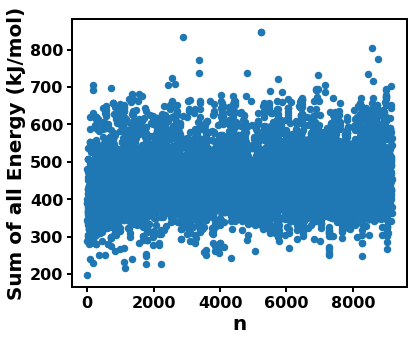

In [31]:
fig,ax=plt.subplots(1,1,figsize=(6,6))


pl.scatter(ax,range(len(data[0][succ[0],8])),data[0][succ[0],8] + data[0][succ[0],7]*(-96.45)+data[0][succ[0],9],ylabel='Sum of all Energy (kJ/mol)',xlabel='n',fontsize=20,labelsize=16)
plt.subplots_adjust(wspace=0.4)

# Dicts

In [22]:
H_atom_energy_dict={
    'M062X':{
        'Def2TZVP':{
        'acetonitrile': -255.1/627.5
        },
        
        '6311++G**':{
            
        'acetonitrile':  -0.508484
        },
        
        'Def2SVPD':{ 
            
         'acetonitrile':  -0.507603
        }
    }
}

proton_dict={
    'M062X':{
        'Def2TZVP':{
        'acetonitrile': -0.223572
        },
        
        'Def2SVPD':{ 
            
         'acetonitrile':  -0.223572
        }
    }
}

H2_dict={
    'M062X':{
        'Def2TZVP':{
        'acetonitrile': -1.169345
        },
        
        'Def2SVPD':{ 
            
         'acetonitrile':  -1.164503
        }
    }
}




bases_dict={
    
    'pyridine':{
        'deprot': -248.214070,
        'prot':-248.654636
    },
    
    'carbonate':{
        'deprot':{ 
            'M062X':{
                'Def2TZVP':{
                    'acetonitrile': -264.567455
                    },
                'Def2SVPD':{
                    'acetonitrile': -264.275312
                    }
            }  
        },
        'prot':{ 
            'M062X':{
                'Def2TZVP':{
                    'acetonitrile': -265.023378
                    },
                'Def2SVPD':{
                    'acetonitrile': -264.728491
                    }
            }  
        }
        
    }
    }
# Energy Levels

bde_dict[1]={}
bde_dict[1]['Reactant_Energy']=-40.474678
bde_dict[1]['BDE 1']={}
bde_dict[1]['BDE 1']['Radical_Energy']=-39.807878

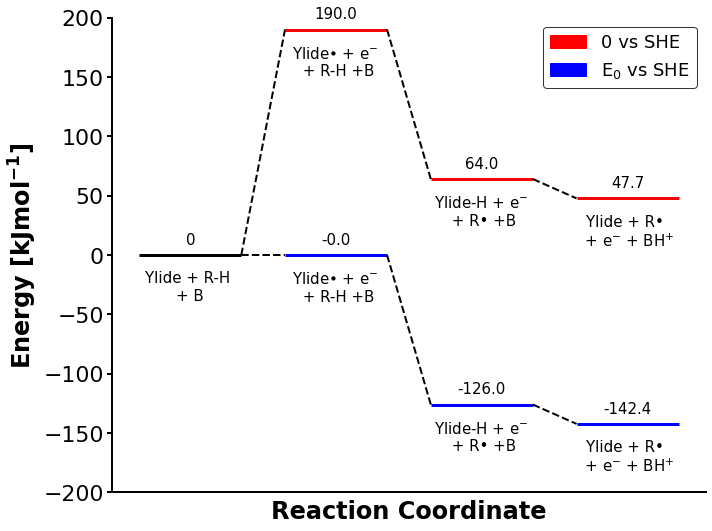

In [46]:
solvorgas='solv'
prot='H$\mathregular{^{+}}$'
elect='e$\mathregular{^{-}}$'

functional='M062X'
basis='Def2SVPD'
solvent='acetonitrile'
sub_id=13


rh=bde_dict[sub_id]['Reactant_Energy'] * 2625.5 #kJ/mol
r_rad= bde_dict[sub_id]['BDE 1']['Radical_Energy']*2625.5 #kJ/mol
h_rad=H_atom_energy_dict[functional][basis][solvent]*2625.5 #kJ/mol
h_plus= proton_dict[functional][basis][solvent]*2625.5 #kJ/mol
h2=-1.169345*2625.5 #kJ/mol
h2=H2_dict[functional][basis][solvent]*2625.5 #kJ/mol

base='carbonate'
b_prot=bases_dict[base]['prot'][functional][basis][solvent]*2625.5 #kJ/mol
b_deprot=bases_dict[base]['deprot'][functional][basis][solvent]*2625.5 #kJ/mol
F=96485 #J/mol e-

fig1,ax1=plt.subplots(figsize=(10,10))

diagram = ED()
diagram.ax=ax1
diagram.fig=fig1
diagram.round_energies_at_digit=1
diagram.color_bottom_text = 'black'
cap=1
colors=['r','b','g']



ylide_id=succ[1][40]
#ylide_id=succ[1][0]
#ylide_id=7514
#ylide_id=7007
cycle=data[1][ylide_id,:]
E0= cycle[7]
Vs=[0,E0]

ylide=cycle[0]*2625.5 #kJ/mol
ylide_rad=cycle[2]*2625.5 #kJ/mol 
ylide_h= cycle[4]*2625.5 #kJ/mol

label1='Ylide + R-H \n+ B'
label2=f'Ylide• + {elect} \n + R-H +B'
label3=f'Ylide-H + {elect} \n + R• +B'
label4=f'Ylide + R• \n + {elect} + B{prot}'

diagram.add_level(0,label1)
labels=[label1,label2,label3,label4]

for i in range(3):
    for k,vs in enumerate(Vs): 
        E1=ylide_rad-(vs +4.298)*(F/1000) - ylide
        E2=E1 + (ylide_h + r_rad - rh - ylide_rad)
        E3=E2 + (b_prot + ylide - ylide_h - b_deprot)
        E=[E1,E2,E3]

        if k==0:
            diagram.add_level(E[i],labels[i+1],color=colors[k])
        else:
            diagram.add_level(E[i],labels[i+1],'last',color=colors[k])
        if i==0:
            diagram.add_link(0,k+1,linewidth=2)
        else:
            #diagram.add_link(k+1+3*(i-1),k+1+3*(i),linewidth=2)
            diagram.add_link(k+1+len(Vs)*(i-1),k+1+len(Vs)*(i),linewidth=2)

            
diagram.plot(ax=ax1,textfontsize=15,linewidth=3) # this is the default ylabel
ax1.set_ylim(-200,200)
#ax1.set_ylim(-80,120)
pl.set(ax1,ylabel="Energy [$\mathregular{kJ mol^{-1}}$]")
fig1.patch.set_facecolor('white')
diagram.ax.axes.get_xaxis().set_visible(True)
diagram.ax.spines['bottom'].set_visible(True)
ax1.set_xticklabels([])
ax1.tick_params(axis='x',length=0)
#plt.gca().axes.get_xaxis().set_visible(True)
ax1.set_xlabel('Reaction Coordinate')   
#plt.legend( ['u','v','u+v'])
red_patch = mpatches.Patch(color='red', label='0 vs SHE')
green_patch = mpatches.Patch(color='blue', label='$\mathregular{E_0}$ vs SHE')
plt.legend(handles=[red_patch,green_patch],fontsize=18,edgecolor='black')
plt.tight_layout()


plt.savefig(f'../Figures/Energy_Landscape_{solvorgas}.png',dpi=600)

## Scatter of Energy Differences

In [14]:
# #Substrate energy order
# bdes=[[30,'BDE 1','pyridine'], [32,'BDE 1','pyridine'],[1,'BDE 1','pyridine'],[30,'BDE 1','carbonate']]
# E=[]

# functional= 'M062X'
# basis = 'Def2SVPD'
# solvent='acetonitrile'

# for j,[b,num,base] in enumerate(bdes):
    
#     E.append([])

#     rh=bde_dict[b]['Reactant_Energy']*2625.5 #kJ/mol
#     r_rad= bde_dict[b][num]['Radical_Energy']*2625.5 #kJ/mol
#     #h_rad=-0.508404*2625.5   #kJ/mol
#     h_rad=H_atom_energy_dict[functional][basis][solvent]*2625.5   #kJ/mol
#     #h_plus= -0.223572*2625.5 #kJ/mol
#     h_plus= proton_dict[functional][basis][solvent]*2625.5  #kJ/mol
#     h2=-1.169345*2625.5      #kJ/mol
    
    
#     b_prot=bases_dict[base]['prot'][functional][basis][solvent]*2625.5 #kJ/mol
#     b_deprot=bases_dict[base]['deprot'][functional][basis][solvent]*2625.5 #kJ/mol
#     #pyridine= -248.214070*2625.5 #kJ/mol
#     #pyridineh= -248.654636*2625.5 #kJ/mol
#     F=96485 #J/mol e-

#     for i in tqdm(succ[1]):

#         cycle=data[1][i,:]
#         E0= cycle[7]
#         #Vs=[0,1,E0]

#         ylide=cycle[0]*2625.5 #kJ/mol
#         ylide_rad=cycle[2]*2625.5 #kJ/mol 
#         ylide_h= cycle[4]*2625.5 #kJ/mol



#         E1=ylide_rad-1*(0 +4.337)*(F/1000) - ylide
#         E2=E1 + (ylide_h + r_rad - rh - ylide_rad)
#         E3=E2 + (b_prot+ ylide - ylide_h - b_deprot)

#         E[j].append([E2-E1,E3-E2])
    
# E=np.array(E)

TypeError: 'float' object is not subscriptable

In [38]:
#Load ML predictions

ml_preds= np.load('../pickled_data/ml_preds.npy')
ml_n,ml_d=np.shape(ml_preds)

(array([   8.,   17.,   69.,  182.,  709., 1717., 2817., 3006.,  535.,
          37.]),
 array([540.5698 , 549.0169 , 557.464  , 565.9111 , 574.35815, 582.8052 ,
        591.25226, 599.69934, 608.1464 , 616.5935 , 625.0406 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

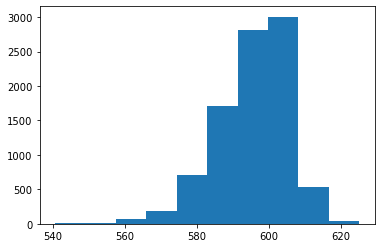

In [40]:
plt.hist(ml_preds[:,1])

In [24]:
bdes=[[13,'BDE 1','carbonate'], [13,'BDE 2','carbonate'],[10,'BDE 1','carbonate'],[11,'BDE 1','carbonate'],[11,'BDE 2','carbonate']]

In [61]:
E_ml=[]

functional= 'M062X'
basis = 'Def2SVPD'
solvent='acetonitrile'


for j,[b,num,base] in enumerate(bdes):

    E_ml.append([])

    rh=bde_dict[b]['Reactant_Energy']*2625.5 #kJ/mol
    r_rad= bde_dict[b][num]['Radical_Energy']*2625.5 #kJ/mol
    h_rad=H_atom_energy_dict[functional][basis][solvent]*2625.5   #kJ/mol
    h_plus= proton_dict[functional][basis][solvent]*2625.5  #kJ/mol
    h2=-1.169345*2625.5      #kJ/mol
    
    
    b_prot=bases_dict[base]['prot'][functional][basis][solvent]*2625.5 #kJ/mol
    b_deprot=bases_dict[base]['deprot'][functional][basis][solvent]*2625.5 #kJ/mol
    F=96485 #J/mol e-

    for i in tqdm(range(ml_n)):

        cycle=data[1][i,:]
        E0= cycle[7]

        ylide=cycle[0]*2625.5 #kJ/mol
        ylide_rad=cycle[2]*2625.5 #kJ/mol 
        ylide_h= cycle[4]*2625.5 #kJ/mol


#         E1=ylide_rad-1*(0 +4.337)*(F/1000) - ylide
#         E2=E1 + (ylide_h + r_rad - rh - ylide_rad)
#         E3=E2 + (b_prot+ ylide - ylide_h - b_deprot)
        
        
        dE1 = ml_preds[i,2] + (r_rad + h_rad -rh) + h2/2 -h_rad
        dE2 = b_prot - h_plus - b_deprot + ml_preds[i,1]
        E_ml[j].append([dE1,dE2])
    
E_ml=np.array(E_ml)

100%|██████████| 9097/9097 [00:00<00:00, 152720.69it/s]


In [62]:
#Substrate energy order
bdes=[[13,'BDE 1','carbonate'], [13,'BDE 2','carbonate'],[10,'BDE 1','carbonate'],[11,'BDE 1','carbonate'],[11,'BDE 2','carbonate']]
E=[]

functional= 'M062X'
basis = 'Def2SVPD'
solvent='acetonitrile'


for j,[b,num,base] in enumerate(bdes):

    E.append([])

    rh=bde_dict[b]['Reactant_Energy']*2625.5 #kJ/mol
    r_rad= bde_dict[b][num]['Radical_Energy']*2625.5 #kJ/mol
    h_rad=H_atom_energy_dict[functional][basis][solvent]*2625.5   #kJ/mol
    h_plus= proton_dict[functional][basis][solvent]*2625.5  #kJ/mol
    h2=-1.169345*2625.5      #kJ/mol
    
    
    b_prot=bases_dict[base]['prot'][functional][basis][solvent]*2625.5 #kJ/mol
    b_deprot=bases_dict[base]['deprot'][functional][basis][solvent]*2625.5 #kJ/mol
    F=96485 #J/mol e-

    for i in tqdm(succ[1]):

        cycle=data[1][i,:]
        E0= cycle[7]
        #Vs=[0,1,E0]

        ylide=cycle[0]*2625.5 #kJ/mol
        ylide_rad=cycle[2]*2625.5 #kJ/mol 
        ylide_h= cycle[4]*2625.5 #kJ/mol



        E1=ylide_rad-1*(0 +4.337)*(F/1000) - ylide
        E2=E1 + (ylide_h + r_rad - rh - ylide_rad)
        E3=E2 + (b_prot+ ylide - ylide_h - b_deprot)

        E[j].append([E2-E1,E3-E2])
    
E=np.array(E)

100%|██████████| 9196/9196 [00:00<00:00, 293718.50it/s]


In [63]:
m,_,_=np.shape(E)
bde_diffs= []

for i in range(m):
    bde_diffs.append(E[0,0,0]-E[i,0,0])

findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVuSans'] not found. Falling back to DejaVu Sans.


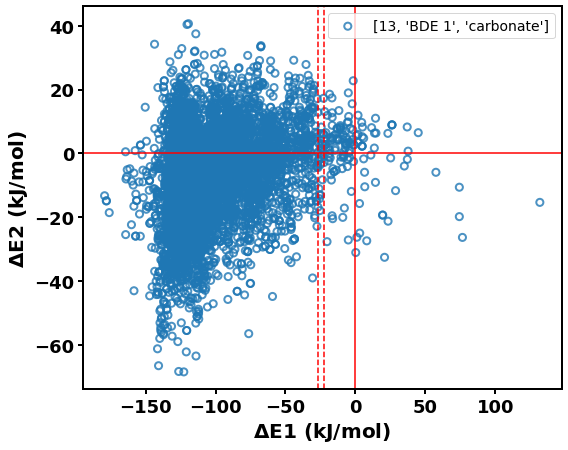

In [12]:
#Idea: Now do the same thing for different substrates:

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

annotations=succ[1]

delta='$\mathregular{\Delta} $'
fig,ax1=plt.subplots(1,1,figsize=(8,8))
solvorgas='solv'

data_id={
    'solv':1,
    'gas':0
}

m,_,_=np.shape(E)


di=data_id[solvorgas]
ax1.axhline(y=0, xmin=0, xmax=1,color='r')
ax1.axvline(x=0, ymin=0, ymax=1,color='r')


for b in bde_diffs[1:3]:
    ax1.axvline(x=b, ymin=0, ymax=1,color='r',ls= '--')


colors=['tab:blue','tab:orange','red','orange']

n,_,_=np.shape(E)




for i in range(1):


    pl.scatter(ax1,E[i][:,0],E[i][:,1],xlabel=f'{delta}E1 (kJ/mol)',ylabel=f'{delta}E2 (kJ/mol)',s=50,facecolor='None',edgecolor=colors[i],label=f'{bdes[i]}',alpha=0.8,fontsize=20,labelsize=18)
    
#     for j, label in enumerate(annotations):
#         plt.text(E[i][j,0],E[i][j,1],str(label))
    ax1.legend(fontsize=14)


plt.tight_layout()
plt.savefig(f'../Figures/Reaction_Energy_Scatter{solvorgas}.png',dpi=600)

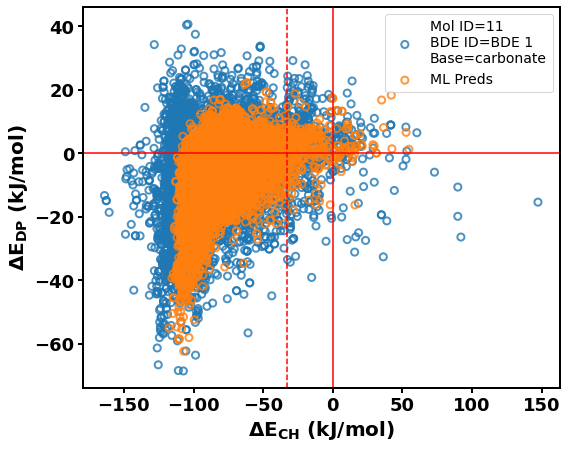

In [75]:
#Idea: Now do the same thing for different substrates:

dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'
ech='$\mathregular{E_{CH} } $'
edp='$\mathregular{E_{DP} } $'
annotations=succ[1]

delta='$\mathregular{\Delta} $'
fig,ax1=plt.subplots(1,1,figsize=(8,8))
solvorgas='solv'

data_id={
    'solv':1,
    'gas':0
}

di=data_id[solvorgas]

ax1.axhline(y=0, xmin=0, xmax=1,color='r')
ax1.axvline(x=0, ymin=0, ymax=1,color='r')

for b in bde_diffs[4:]:
    ax1.axvline(x= b - bde_diffs[3], ymin=0, ymax=1,color='r',ls= '--')


colors=['tab:blue','tab:orange','grey','tab:blue']

n,_,_=np.shape(E)


#Which bdes to plot
for i in [3]:
    pl.scatter(ax1,E[i][:,0],E[i][:,1],xlabel=f'{delta}{ech} (kJ/mol)',ylabel=f'{delta}{edp} (kJ/mol)',s=50,facecolor='None',edgecolor=colors[i],label=f'Mol ID={bdes[i][0]}\nBDE ID={bdes[i][1]}\nBase={bdes[i][2]}',alpha=0.8,fontsize=20,labelsize=18)

    pl.scatter(ax1,E_ml[i][:,0],E_ml[i][:,1],xlabel=f'{delta}{ech} (kJ/mol)',ylabel=f'{delta}{edp} (kJ/mol)',s=50,facecolor='None',edgecolor='tab:orange',label=f'ML Preds',alpha=0.8,fontsize=20,labelsize=18)


#     for j, label in enumerate(annotations):
#         plt.text(E[i][j,0],E[i][j,1],str(label))
    ax1.legend(fontsize=14)


plt.tight_layout()
plt.savefig(f'../Figures/Reaction_Energy_Scatter{solvorgas}_2.png',dpi=600)

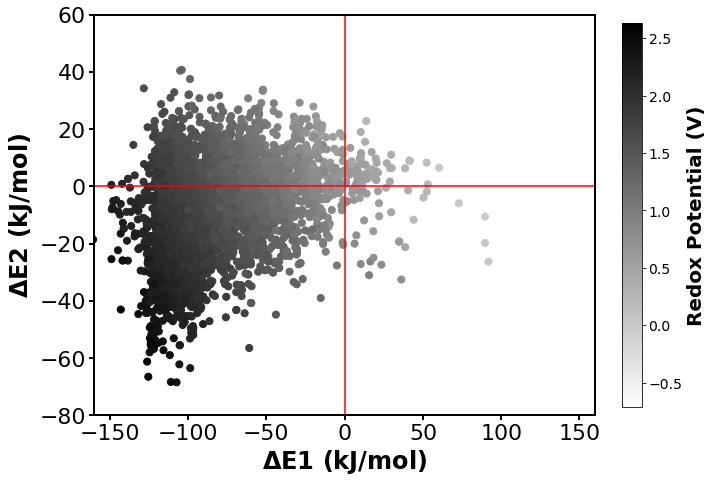

In [20]:
dpfe='$\mathregular{\Delta G_{DP}}$'
ghb='$\mathregular{\Delta G_{Hbind} } $'

annotations=succ[1]

delta='$\mathregular{\Delta} $'
fig,ax1=plt.subplots(1,1,figsize=(10,10))
solvorgas='solv'

data_id={
    'solv':1,
    'gas':0
}

di=data_id[solvorgas]
ax1.axhline(y=0, xmin=0, xmax=1,color='r')
ax1.axvline(x=0, ymin=0, ymax=1,color='r')
colors=['blue','black','red','orange']

n,_,_=np.shape(E)

c_s=data[1][succ[1],7]

ax1.set_xlim(-160,160)
ax1.set_ylim(-80,60)

sc=ax1.scatter(E[i][:,0],E[-1][:,1],s=50,cmap='binary',c=c_s)
# for j, label in enumerate(c_s):
#     plt.text(E[i][j,0],E[i][j,1],str(round(label,2)))


cb=plt.colorbar(sc,fraction=0.035, pad=0.05)
cb.set_label(label='Redox Potential (V)',size=20,weight='bold')
cb.ax.tick_params(labelsize=14) 
pl.set(ax1,ylabel=f'{delta}E2 (kJ/mol)',xlabel=f'{delta}E1 (kJ/mol)',edgecolor='black')


#pl.scatter(ax1,E[i][:,0],E[-1][:,1],xlabel=f'{delta}E1 (kJ/mol)',ylabel=f'{delta}E2 (kJ/mol)',s=50,facecolor=colors[1],edgecolor=colors[1],label=f'{bdes[-1]}')


plt.tight_layout()
plt.savefig(f'../Figures/Reaction_Energy_Scatter_wRedoxPot{solvorgas}.png',dpi=600)

### Get Candidates

In [76]:
#Considering substrate 13
E1_lim= [0 , bde_diffs[1],bde_diffs[2],bde_diffs[3],bde_diffs[4]]
E2_lim =[-100,  100]
y_array=np.array(y)

In [77]:
candidates = [np.where( (E[0,:,0] < E1_lim[0]) & ( E[0,:,0] > E1_lim[2] ) & (E[0,:,1] < 0)),
             
             np.where( (E[0,:,0] < E1_lim[2]) & ( E[0,:,0] > E1_lim[1] ) & (E[0,:,1] < 0)),
              
             np.where( (E[0,:,0] < E1_lim[3]) & ( E[0,:,0] > E1_lim[4] ) & (E[0,:,1] < 0)), # Substrate 11 selecting weakest bond
              
             np.where( (E[0,:,0] > E1_lim[0]) & (E[0,:,1] < 0)), #cannot activate anything  
              
             np.where( (E[0,:,0] < E1_lim[3]) & (E[0,:,1] < 0)) #Activates Everything
             ]


true_candidates= [ np.array(succ[1])[c] for c in candidates]

candidates_energy = [ [ [y_array[i],data[1][i][9],i] for i in tc]  for tc in true_candidates  ]
candidate_ylides = [ y_array[tc] for tc in true_candidates] 

In [78]:
sorted_candidates=[]
for ce in candidates_energy:
    sorted_candidates.append(sorted(ce,key=lambda x : x[1],reverse=True))

In [79]:
candidate_mols = [ [Chem.MolFromSmiles(s[0]) for s in cy] for cy in sorted_candidates]

In [80]:
len(sorted_candidates[2])

129

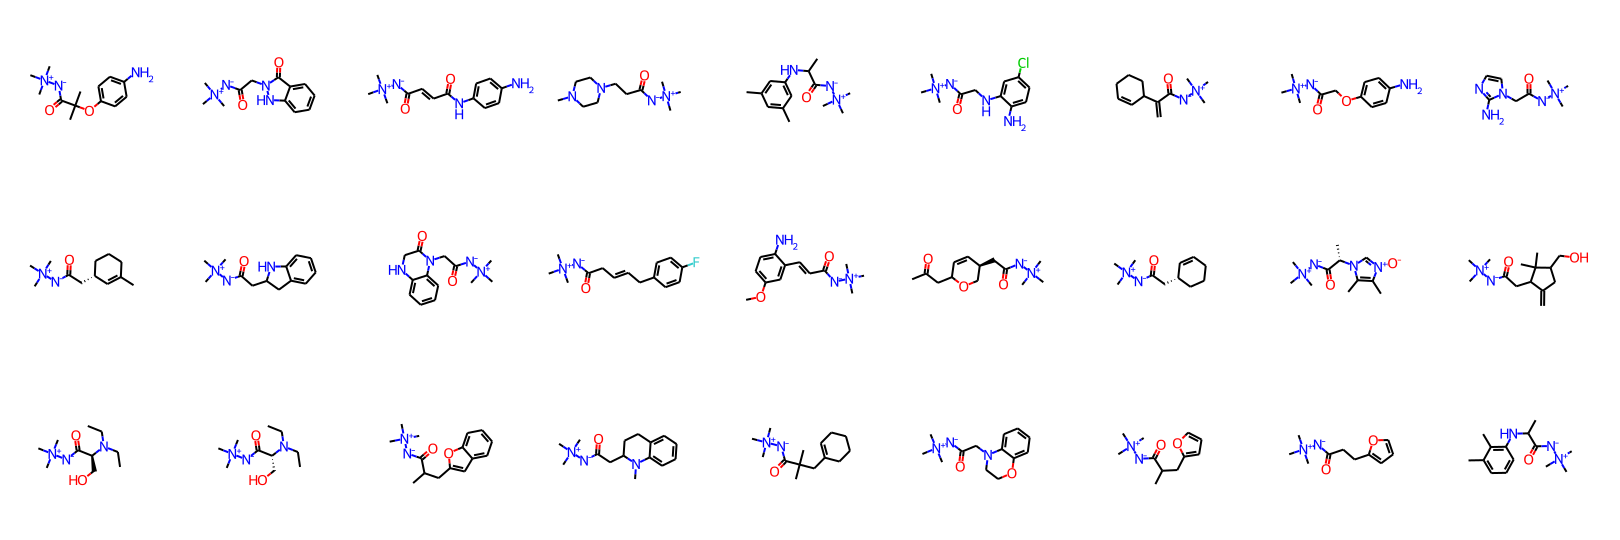

In [171]:
mcb= [Chem.Mol(i.ToBinary()) for i in candidate_mols[0][:]]
size=(180,180)
#mcb= [Chem.Kekulize(i) for i in mcb]
#mcb= [rdDepictor.Compute2DCoords(i) for i in mcb]
drawer = rdMolDraw2D.MolDraw2DSVG(size[0]*9,size[1]*3,size[0],size[1])
drawer.drawOptions().minFontSize=14
drawer.DrawMolecules(mcb)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg.replace('svg:','')
SVG(svg)

In [172]:
cairosvg.svg2png(svg,write_to="../Figures/candidates_1.png",dpi=1000,scale=3.0)

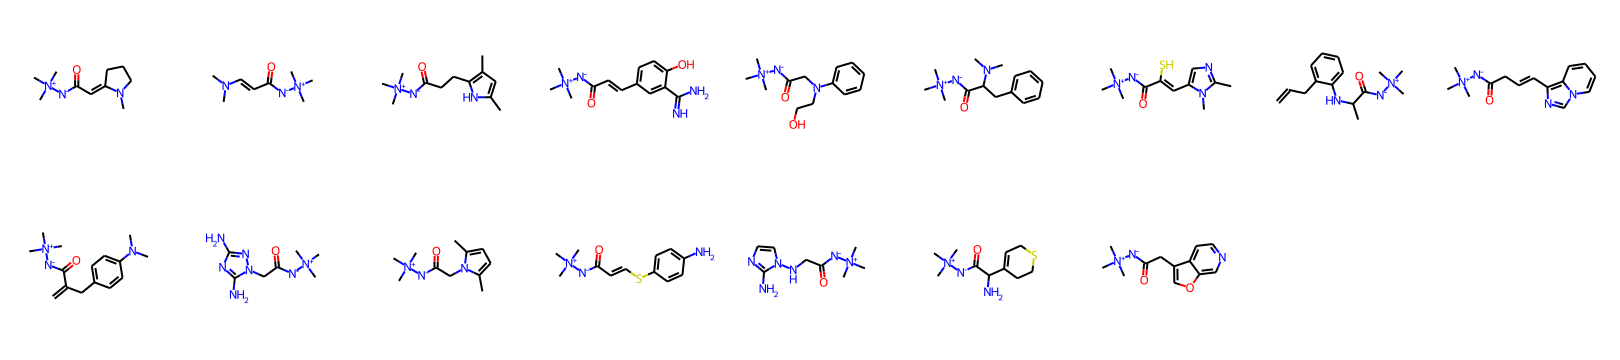

In [173]:
mcb= [Chem.Mol(i.ToBinary()) for i in candidate_mols[1][:]]
size=(180,180)
#mcb= [Chem.Kekulize(i) for i in mcb]
#mcb= [rdDepictor.Compute2DCoords(i) for i in mcb]
drawer = rdMolDraw2D.MolDraw2DSVG(size[0]*9,size[1]*2,size[0],size[1])
drawer.drawOptions().minFontSize=12
drawer.DrawMolecules(mcb)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg.replace('svg:','')
SVG(svg)

In [174]:
cairosvg.svg2png(svg,write_to="../Figures/candidates_2.png",dpi=1000,scale=3.0)

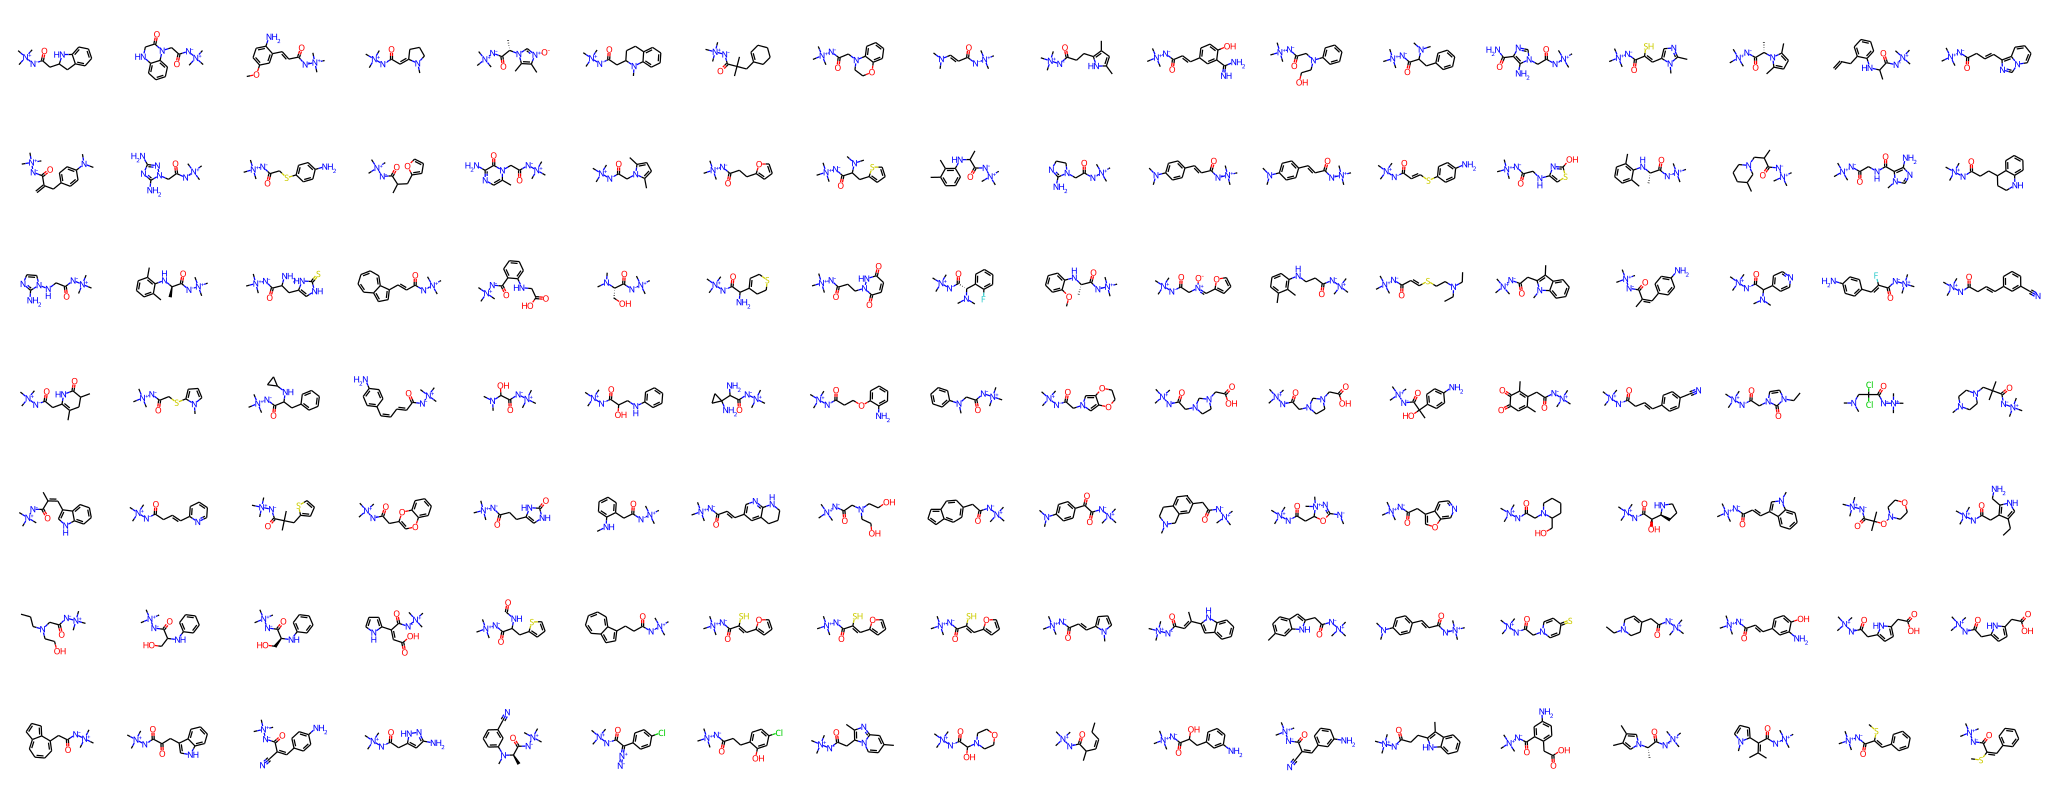

In [81]:
mcb= [Chem.Mol(i.ToBinary()) for i in candidate_mols[2][:]]
size=(180,180)
#mcb= [Chem.Kekulize(i) for i in mcb]
#mcb= [rdDepictor.Compute2DCoords(i) for i in mcb]
drawer = rdMolDraw2D.MolDraw2DSVG(size[0]*18,size[1]*7,size[0],size[1])
drawer.drawOptions().minFontSize=14
drawer.DrawMolecules(mcb)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg.replace('svg:','')
SVG(svg)

In [38]:
cairosvg.svg2png(svg,write_to="../Figures/candidates_3.png",dpi=1000,scale=3.0)